<a href="https://colab.research.google.com/github/ARtoRiAs10/audiousingCVAE/blob/main/basic%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)


In [2]:
pip install xgboost -U


In [3]:
pip install librosa -U


In [4]:
pip install hyperopt

In [6]:
import os
from tqdm import tqdm
import pickle
import scipy
import sys
import pandas as pd

In [8]:
import numpy as np
import IPython
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [10]:
import librosa
import librosa.display
import librosa.display as lplt


In [9]:
from tensorflow import keras
from keras.models import Sequential
from IPython.display import Audio

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

Loading and  PREPROCESSING THE DATA

In [13]:
final_data = pd.read_csv("/content/features_3_sec.csv")

In [14]:
final_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [15]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [17]:
final_data.shape

(9990, 60)

In [18]:
final_data.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [20]:
final_data = final_data.drop(labels='filename', axis=1)

In [24]:
audio = "/content/classical.00033.wav"

data , sr = librosa.load(audio)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [25]:
librosa.load(audio, sr=45600)

(array([-0.00422784, -0.00627998, -0.00660378, ..., -0.0102866 ,
        -0.00883082, -0.00440945], dtype=float32),
 45600)

In [26]:
IPython.display.Audio(data, rate=sr)

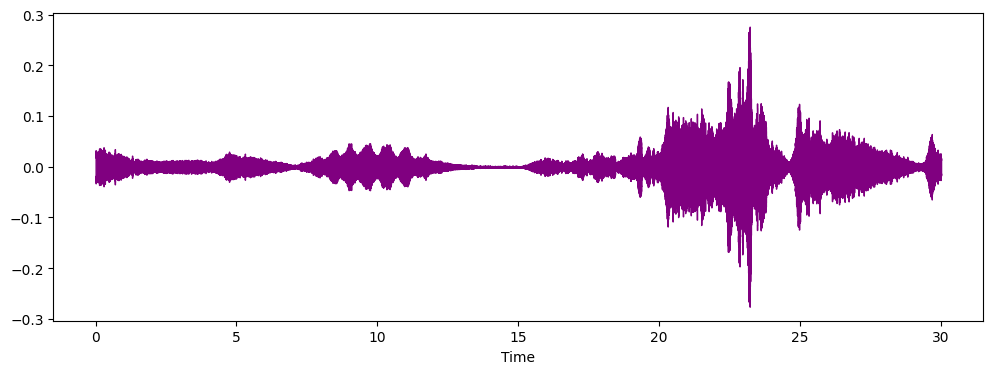

In [27]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, color = "Purple")
plt.show()

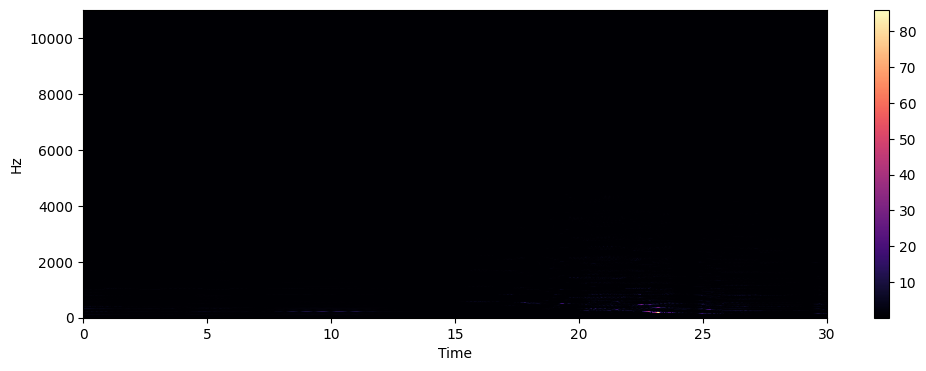

In [28]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

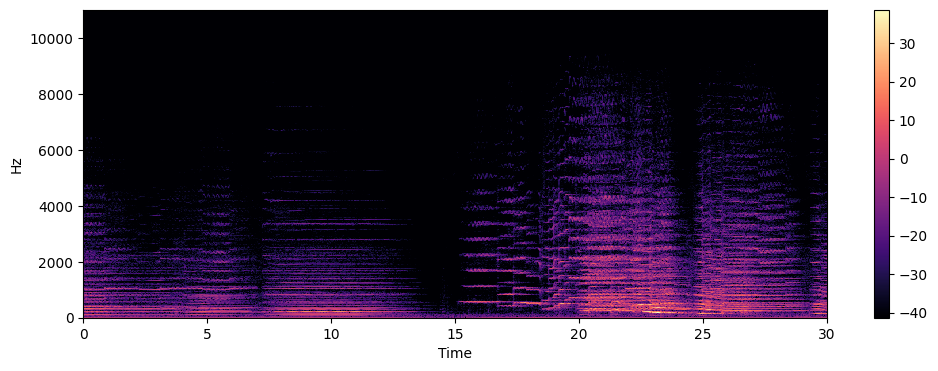

In [29]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [42]:
data , sr = librosa.load(audio)
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sr, alpha=0.4, color='Purple')

TypeError: ignored

In [38]:
chroma = librosa.feature.chroma_stft(data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='BuPu')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

TypeError: ignored

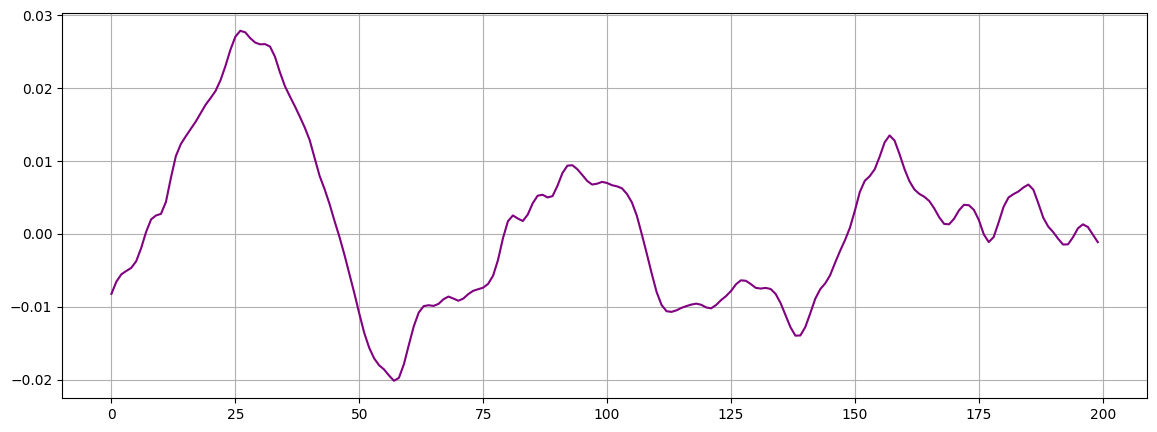

In [43]:
start = 1000
end = 1200
plt.figure(figsize=(14,5))
plt.plot(data[start:end], color='Purple')
plt.grid()

In [44]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print("The number of zero crossings is:",sum(zero_cross_rate))

The number of zero crossings is: 10


In [45]:
class_list = final_data.iloc[:, -1]
convertor = LabelEncoder()

In [46]:
y= convertor.fit_transform(class_list)

In [47]:
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
print(final_data.iloc[:, :-1])

In [49]:
fit = StandardScaler()
X = fit.fit_transform(np.array(final_data.iloc[:, :-1], dtype = float))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [51]:
len(y_train)

6693

In [53]:
len(y_test
    )

3297

In [55]:
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                   metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                     batch_size=batch_size)

In [56]:
def plotValidate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

<ipython-input-57-7631b6b3b653>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = final_data.corr()


<Axes: >

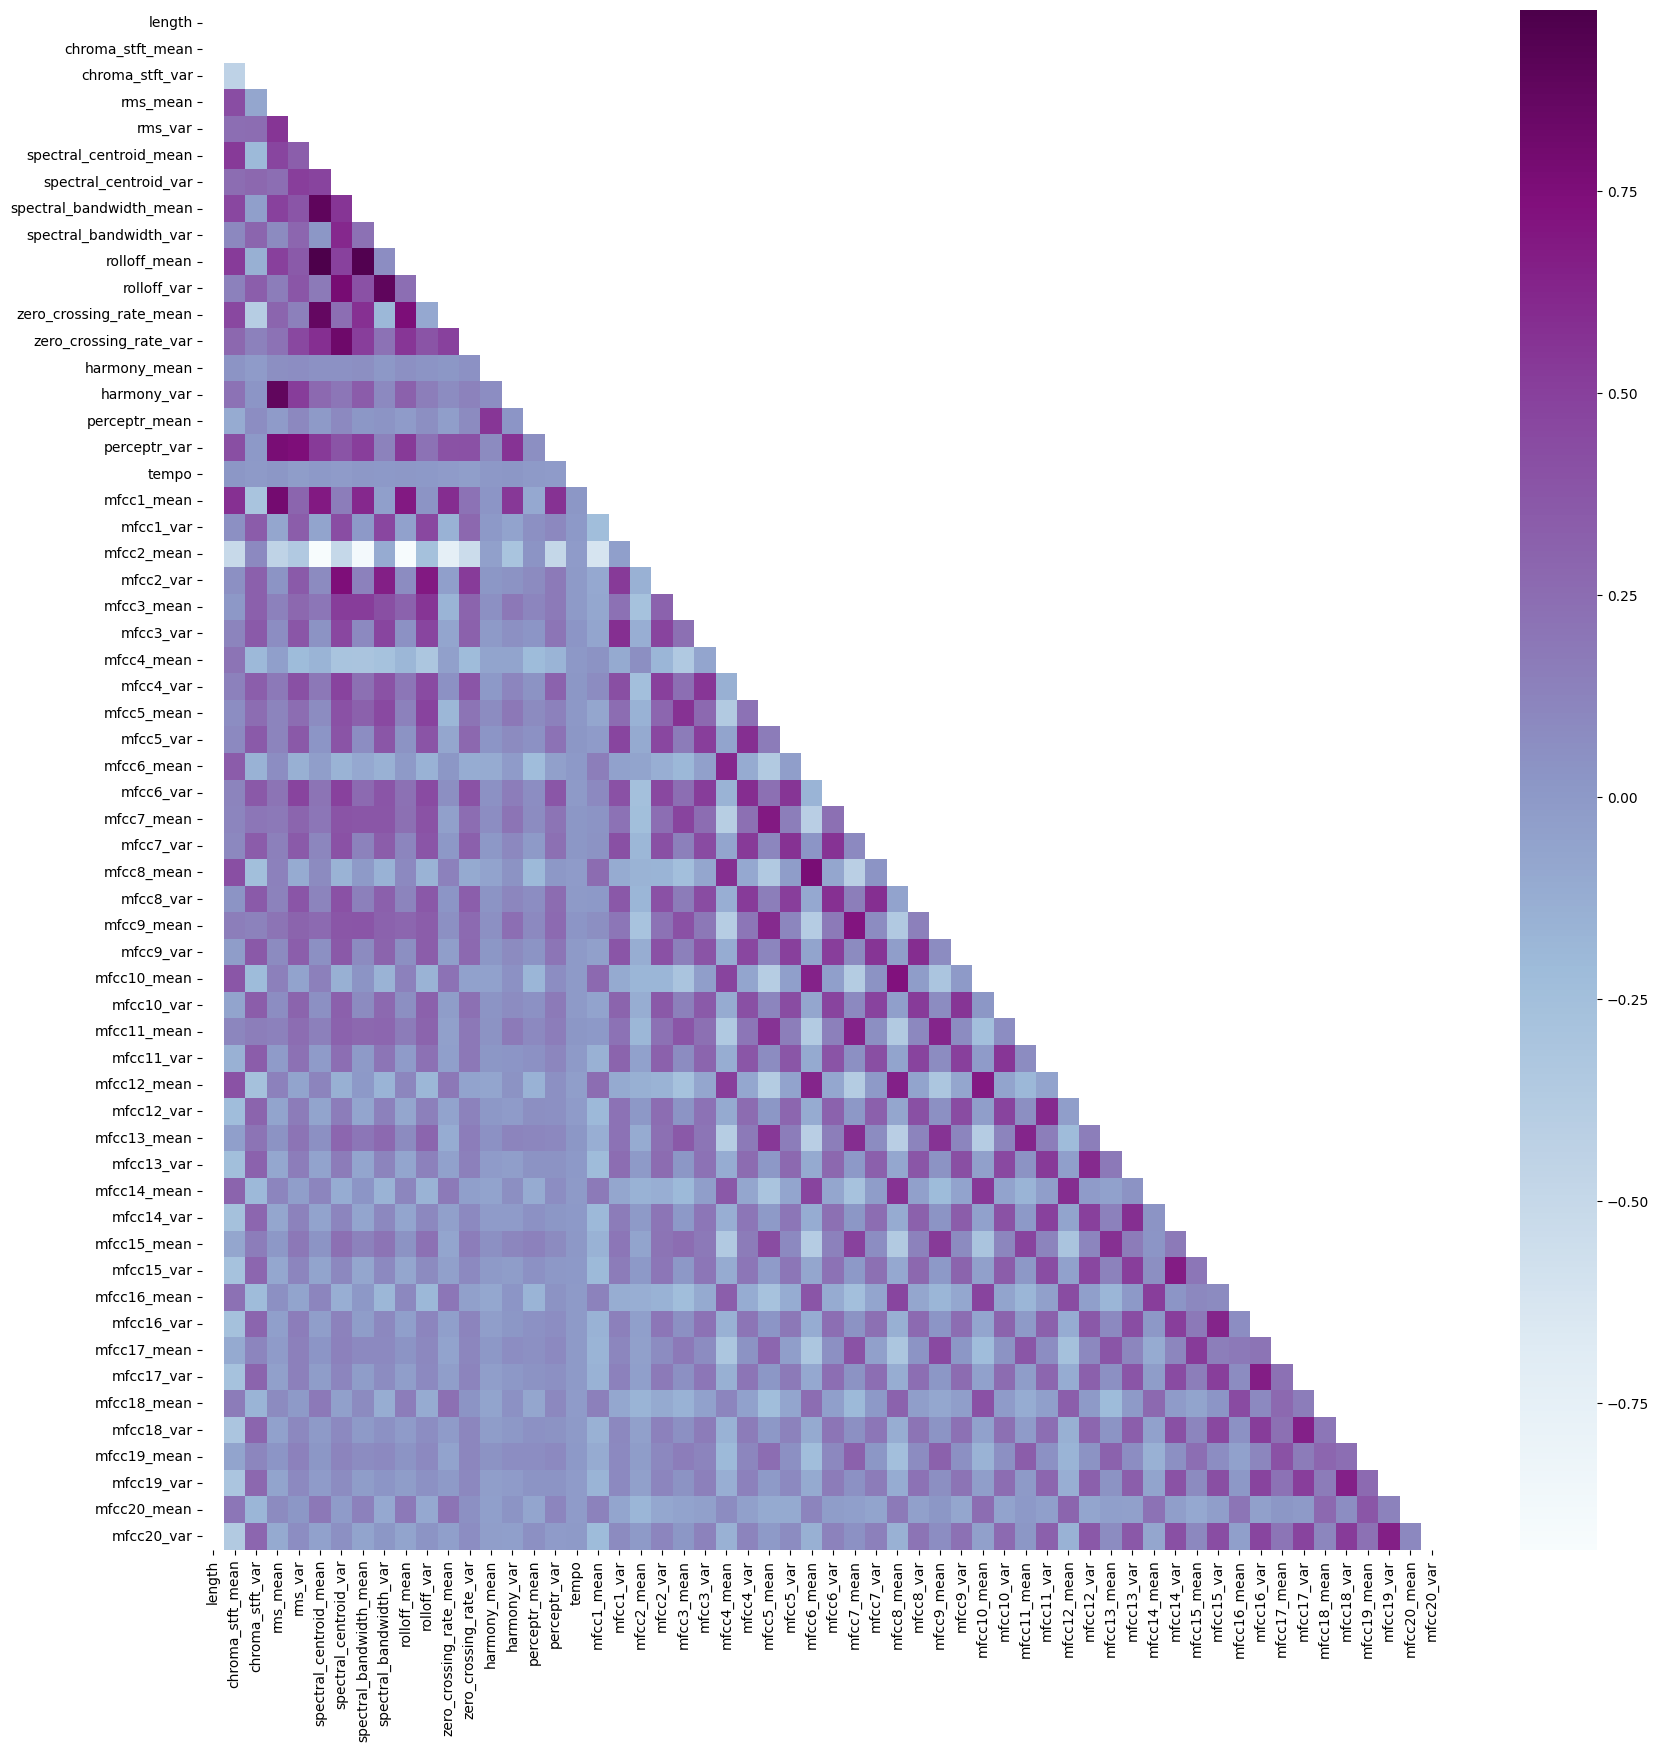

In [57]:
corr = final_data.corr()
#Creation of a mask for the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap="BuPu")

In [58]:
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [59]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(y_test, y_pred_test, labels=target_names)}')

Training accuracy: 0.9992529508441655
Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       675
           1       1.00      1.00      1.00       676
           2       1.00      1.00      1.00       680
           3       1.00      1.00      1.00       673
           4       1.00      1.00      1.00       681
           5       1.00      1.00      1.00       684
           6       1.00      0.99      1.00       658
           7       1.00      1.00      1.00       628
           8       1.00      1.00      1.00       683
           9       0.99      1.00      1.00       655

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693

Testing accuracy: 0.9017288444040037
Testing:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88       325
           1       0.94      0.98   

<Axes: >

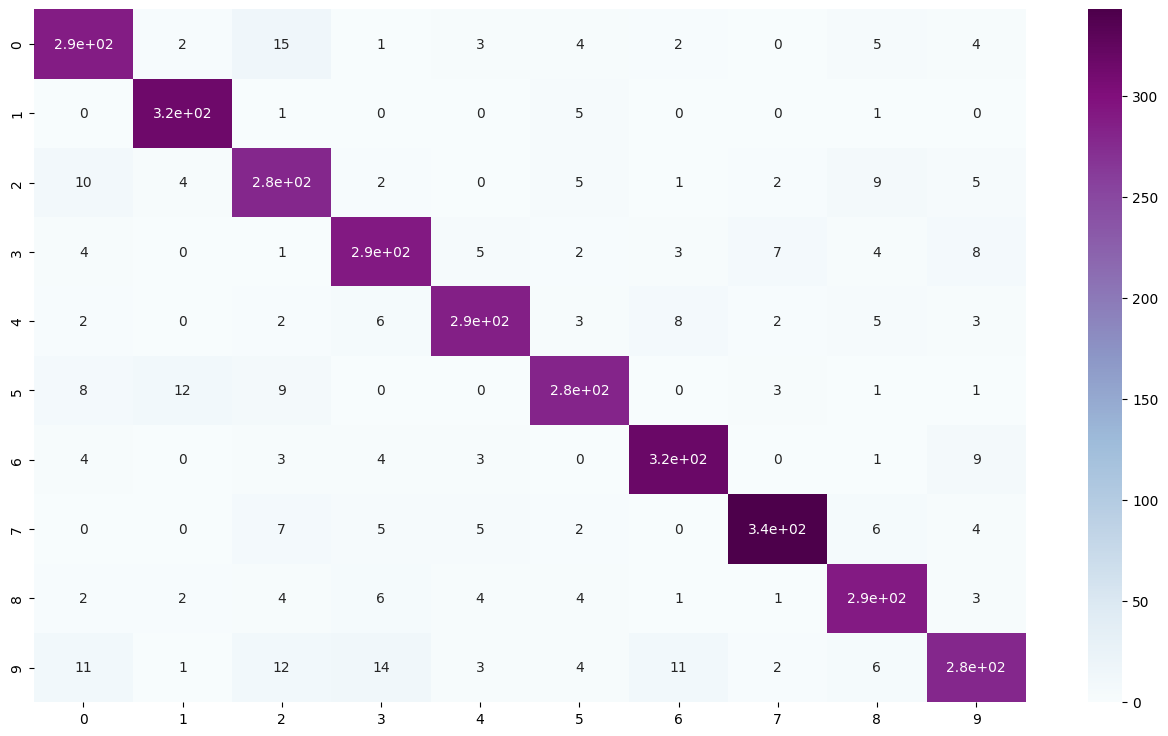

In [60]:
conf_mat = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (16, 9))
sns.heatmap(conf_mat,cmap="BuPu", annot=True, xticklabels = target_names, yticklabels = target_names )

In [62]:
model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(10, activation="softmax"),

])
print(model.summary())
model_history = trainModel(model=model, epochs=150, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               30208     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [63]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("The test loss is :",test_loss)
print("\nThe test Accuracy is :",test_accuracy*100)

26/26 [==============================] - 0s 5ms/step - loss: 0.3587 - accuracy: 0.9257
The test loss is : 0.35874342918395996

The test Accuracy is : 92.56899952888489


Validation Accuracy 0.9287230968475342


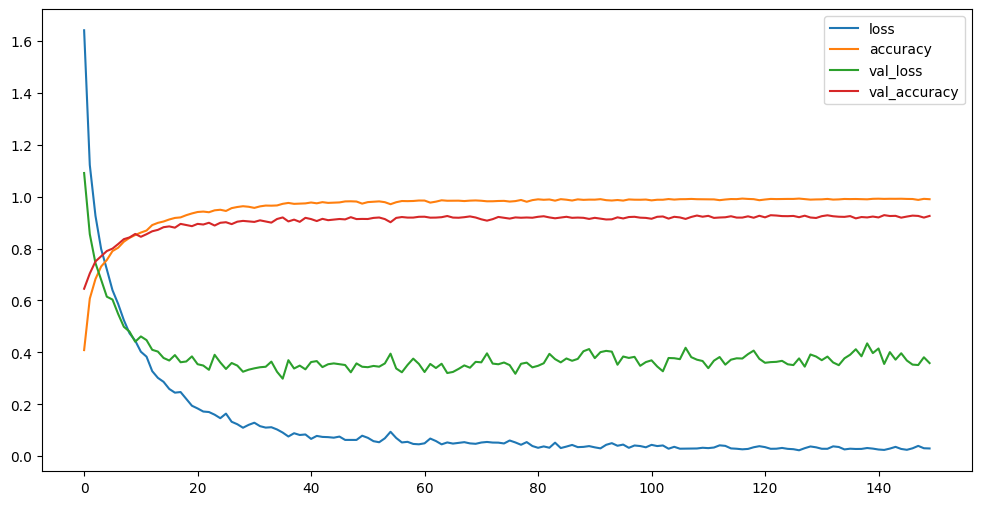

In [64]:
plotValidate(model_history)

#Done
